In [1]:
import numpy as np
import pandas as pd
import rustworkx as rx
import networkx as nx
import matplotlib.pyplot as plt
import ipywidgets as widgets
from tests_and_graphing import *

In [2]:
def draw_graph(A:np.ndarray, group_labels=None):
    n = A.shape[0]
    G = nx.from_numpy_array(A, create_using=nx.Graph)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(6, 6))
    if group_labels is None:
        nx.draw(G, pos=pos, with_labels=False, node_color="lightblue", edge_color="black")
    else:
        unique_groups = list(set(group_labels))
        colors = plt.cm.get_cmap("tab10", len(unique_groups))
        color_map = {group: colors(i) for i, group in enumerate(unique_groups)}
        node_colors = [color_map[group_labels[node]] for node in G.nodes]
        print(node_colors)
        nx.draw(G, pos=pos, with_labels=False, node_color=node_colors, edge_color="black")

# graph structure

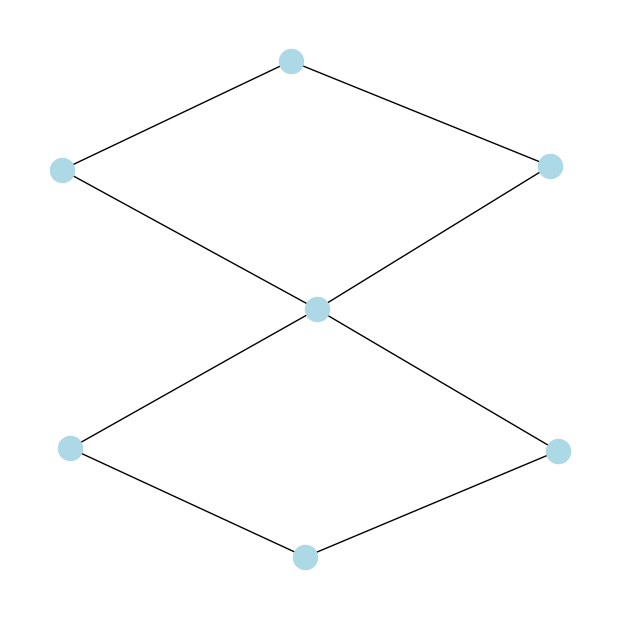

In [3]:
k = 2

AL = {
    0: [1,3],
    1: [0,2],
    2: [1,3],
    3: [0,2,4,6],
    4: [3,5],
    5: [4,6],
    6: [3,5],
}

# Get the adjacency matrix as a NumPy array
G = nx.from_dict_of_lists(AL)
A = nx.to_numpy_array(G)
D = np.diag(np.sum(A, axis=0)) #find the degree of each node
m, n = A.shape
draw_graph(A)

# Doing an SVD decomposition on the |L|= D + A

In [4]:
L_ABS = D + A
U, S, V = np.linalg.svd(L_ABS)
S = np.diag(S)
U_k = U[:,0:k]
S_k = S[0:k,0:k]
V_k = V[:k,:]

print(np.round(U_k @ S_k @ V_k))
print(np.round(U_k, decimals = 3))
print(np.round(V_k, decimals=3))
print(np.round(V, decimals = 3))

[[ 1.  1.  1.  1.  0. -0.  0.]
 [ 1.  1.  1.  1. -0. -1. -0.]
 [ 1.  1.  1.  1. -0. -0. -0.]
 [ 1.  1.  1.  3.  1.  1.  1.]
 [ 0. -0.  0.  1.  1.  1.  1.]
 [-0. -1. -0.  1.  1.  1.  1.]
 [ 0. -0.  0.  1.  1.  1.  1.]]
[[-0.281  0.354]
 [-0.164  0.5  ]
 [-0.281  0.354]
 [-0.794  0.   ]
 [-0.281 -0.354]
 [-0.164 -0.5  ]
 [-0.281 -0.354]]
[[-0.281 -0.164 -0.281 -0.794 -0.281 -0.164 -0.281]
 [ 0.354  0.5    0.354  0.    -0.354 -0.5   -0.354]]
[[-0.281 -0.164 -0.281 -0.794 -0.281 -0.164 -0.281]
 [ 0.354  0.5    0.354  0.    -0.354 -0.5   -0.354]
 [ 0.168  0.575  0.168 -0.476  0.168  0.575  0.168]
 [-0.707 -0.     0.707  0.    -0.    -0.    -0.   ]
 [-0.     0.    -0.    -0.     0.707 -0.    -0.707]
 [-0.354  0.5   -0.354  0.     0.354 -0.5    0.354]
 [ 0.378 -0.378  0.378 -0.378  0.378 -0.378  0.378]]


In [5]:
print(L_ABS)

[[2. 1. 0. 1. 0. 0. 0.]
 [1. 2. 1. 0. 0. 0. 0.]
 [0. 1. 2. 1. 0. 0. 0.]
 [1. 0. 1. 4. 1. 0. 1.]
 [0. 0. 0. 1. 2. 1. 0.]
 [0. 0. 0. 0. 1. 2. 1.]
 [0. 0. 0. 1. 0. 1. 2.]]


# Compute cosine matrix

In [6]:
CM = cosine_similarity(L_ABS, 2)
print(np.round(CM, decimals = 3))


[[ 1.     0.914  1.     0.783  0.227 -0.189  0.227]
 [ 0.914  1.     0.914  0.462 -0.189 -0.572 -0.189]
 [ 1.     0.914  1.     0.783  0.227 -0.189  0.227]
 [ 0.783  0.462  0.783  1.     0.783  0.462  0.783]
 [ 0.227 -0.189  0.227  0.783  1.     0.914  1.   ]
 [-0.189 -0.572 -0.189  0.462  0.914  1.     0.914]
 [ 0.227 -0.189  0.227  0.783  1.     0.914  1.   ]]


# Reorder cosine matrix

In [7]:
INDEX = [] # global reordering index
CM_COPY = CM.copy()
indices = list(range(0,CM.shape[1]))
while(len(indices) > 1):
    # sort by cosine similarity
    similarity_list = CM_COPY[0,:]
    new_indices = np.argsort(similarity_list)[::-1]
    
    # rearrange matrix
    indices = [indices[i] for i in new_indices]
    CM_COPY = CM_COPY[np.ix_(new_indices,new_indices)]

    # remove and update
    INDEX.append(indices[0])
    indices.pop(0)
    CM_COPY = CM_COPY[1:,1:]
INDEX.append(indices[0])
del CM_COPY
print(INDEX)
CM_REORDERED = CM[np.ix_(INDEX, INDEX)]
CM_REORDERED

# this only mismatches the paper's example because vertex 2 is exactly similar to vertex 0 so their ordering doesnt matter

[2, 0, 1, 3, 4, 6, 5]


array([[ 1.        ,  1.        ,  0.91354747,  0.78311587,  0.22654092,
         0.22654092, -0.18920188],
       [ 1.        ,  1.        ,  0.91354747,  0.78311587,  0.22654092,
         0.22654092, -0.18920188],
       [ 0.91354747,  0.91354747,  1.        ,  0.46247664, -0.18920188,
        -0.18920188, -0.57223071],
       [ 0.78311587,  0.78311587,  0.46247664,  1.        ,  0.78311587,
         0.78311587,  0.46247664],
       [ 0.22654092,  0.22654092, -0.18920188,  0.78311587,  1.        ,
         1.        ,  0.91354747],
       [ 0.22654092,  0.22654092, -0.18920188,  0.78311587,  1.        ,
         1.        ,  0.91354747],
       [-0.18920188, -0.18920188, -0.57223071,  0.46247664,  0.91354747,
         0.91354747,  1.        ]])

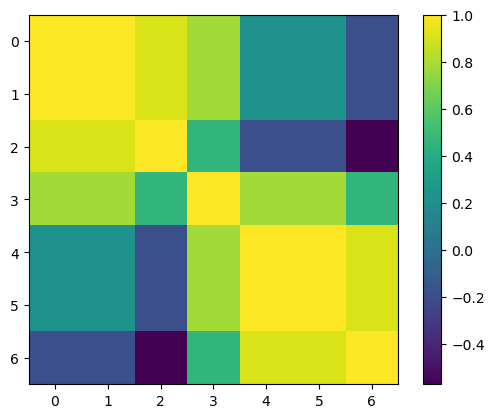

In [8]:
import matplotlib.pyplot as plt

plt.imshow(CM_REORDERED, cmap='viridis')
plt.colorbar()
plt.show()

In [9]:
print(community_detection(CM_REORDERED, 0.9))

print(community_strength(CM_REORDERED, .9))

[slice(0, 3, None), slice(3, 4, None), slice(4, 7, None)]
[[ 2.22044605e-16  0.00000000e+00 -8.64525305e-02]
 [ 2.22044605e-16  0.00000000e+00 -8.64525305e-02]
 [-8.64525305e-02 -8.64525305e-02 -1.11022302e-16]]
[[0.]]
[[ 2.22044605e-16  0.00000000e+00 -8.64525305e-02]
 [ 2.22044605e-16 -1.11022302e-16 -8.64525305e-02]
 [-8.64525305e-02 -8.64525305e-02  0.00000000e+00]]
[np.float64(0.878), np.float64(1.0), np.float64(0.878)]
